# Decision Tree and Random Forest: Student Performance

# Introduction

What increases a student's chance of passing or failing a class in secondary school?

Most of us would assume that the number of absences, participation in class, and past grades are enough to predict a student's performance. However, there are other elements that might not be apparent or simple to measure but have an impact on a student's academic success, such as their home life, family, aspirations, and even their health.

Analysing and predicting student performance is important because it enables schools and teachers to address the problem, provide support, and make informed decisions regarding academic programmes.

In this project, we will develop a machine learning model that focuses on predicting the final grades of Portuguese secondary school students based on key social, demographic, and past school performance attributes. The datasets that we will use to train and test our algorithm are the [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance) from the Center for Machine Learning and Intelligent Systems, both from Portuguese public secondary schools, containing Math and Portuguese Language marks collected during the 2005-2006 school year. The combined dataset contains 1044 observations and 33 attributes. (Note: There are 382 students present in both datasets, Portuguese and Math grades, but we are stacking them instead of merging them in order to artificially increase our training data.)
Let's load our data and make an exploratory analysis to find the key attributes for our model:

# Load the datasets

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Load these datasets used in the paper "USING DATA MINING TO PREDICT SECONDARY SCHOOL STUDENT PERFORMANCE" 
#by Paulo Cortez and Alice Silva
#This dataset will be used for training and testing

#Math course data
grades_mat=pd.read_csv("student-mat.csv", sep=";")
#Portuguese Language course data
grades_por=pd.read_csv("student-por.csv",sep=";")
#Concatenating both datasets
grades=pd.concat([grades_mat,grades_por],ignore_index=True)
#Print information about the combined datasets
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher  

In Portugal, the grading system is based on a 20-point grading scale. During the academic year, students are graded three times, with the final test determining the grade for the course.

We will start by transforming the final grades that go from 0 to 20 (G3) into a new column called "Pass" that will have a binary value. Grades under or equal to 9 will be classified as failed with a 0, and grades over 9 will be classified as passed with a 1. This decision is based on the ["Using Data Mining to predict secondary school performance" paper.](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://www3.dsi.uminho.pt/pcortez/student.pdf)

In [24]:
#We start by creating a for loop that will assign a value of 1 or 0 to a list
Pass=[]
for grade in grades["G3"]:
    if grade>9:
        Pass.append(1)
    else:
        Pass.append(0)
#We create a new column in the database "grades" named "Pass"        
grades["Pass"]= Pass

# shift column 'Pass' to first position
first_column = grades.pop('Pass')

# insert column using insert(position,column_name,first_column) function
grades.insert(0, 'Pass', first_column)

First, we calculate the probability of passing the course without using any feature information:

In [25]:
pass_prob = sum(grades.Pass) / len(grades)
print('Probability of passing is:', np.round(pass_prob,2))
acc_tb=round(1-pass_prob,2)
#We could label every student as failed and achieve an accuracy of:
print(f"Accuracy to beat: {acc_tb}")

Probability of passing is: 0.78
Accuracy to beat: 0.22


If we use the simplest model that makes every student fail the class, we would be correct 22% of the time. The decision tree model should beat that accuracy.

# Methods

To answer the research question,a decision tree classifier to do a binary classification (Pass or Fail) was created using the student performance datasets containing information on 382 students with Math and Portuguese Language grades.

**Data collection and preprocessing:** The datasets used for this algorithm were the [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance) from the Center for Machine Learning and Intelligent Systems, both from Portuguese public secondary schools containing Math and Portuguese Language marks collected during the 2005-2006 school year. The combined dataset contains 1044 observations and 33 attributes.
Both datasets were stacked to artificially increase our training data and reduce the impact of the mild class imbalance. The dataset was preprocessed by making a simple feature selection and converting object types to numeric binary data.

**Feature selection:** A correlation analysis and feature importance ranking were used to select the most relevant features for the decision tree model.

**Model development:** The Python libraries scikit-learn and matplotlib were used to create and visualize the decision tree model. This model was based on the "Decision Trees and Random Forests: The Titanic Disaster" model by 
Mario Gutiérrez-Roig and Lisa Voigt, Lecturers in Data Science and Statistics at the University of Essex. The model was trained with the same original dataset. However, the training data was artificially increased by stacking both datasets together to improve the performance.

**Model evaluation**: To evaluate the performance, we will use a max-depth function and k-fold cross-validation to estimate which depth is optimal for the decision tree.

**Comparison with other models**: We will compare the performance of our decision tree model with random forests of 10 and 100 trees.

**Model interpretation**: The decision tree model will help identify the most important features to be able to predict student performance.

To choose which features to include, let's start by doing a correlation and exploratory analysis.

      Pass       age     Medu      Fedu  traveltime  studytime  failures  \
Pass   1.0 -0.134276  0.10646  0.105579   -0.033852   0.108553 -0.367183   

        famrel  freetime     goout      Dalc      Walc    health  absences  \
Pass  0.042706 -0.064414 -0.106506 -0.089581 -0.076593 -0.034222 -0.119142   

            G1        G2        G3  
Pass  0.613927  0.666289  0.729693  


<AxesSubplot: >

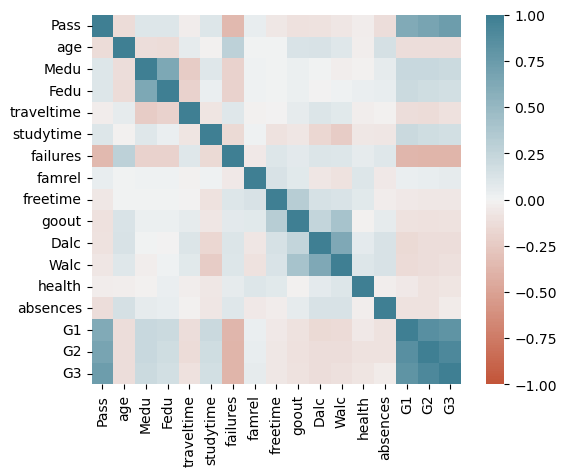

In [26]:
#To find the main features : corr analysis
corr_matrix=grades.corr()
print(corr_matrix[0:1])
sns.heatmap(corr_matrix,vmin=-1,vmax=1,center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True)

According to our correlation matrix, there is no strong correlation between "Pass" and our independent variables.
However, we found a strong positive correlation between "Mother Education Level" and "Father Education Level" (0.642063).

Also, weak correlations between "Pass" and "failures" (-0.367183), "Pass" and "age" (-0.134276), and "Pass" and "absences" (-0.119142) are present. We will ignore G1, G2, and G3 because Pass was created based on them.

There is a surprising small correlation between "Pass" and "studytime" (0.108553). For this reason, we will leave this variable out.

For this exercise, we will use the following:

*Pass*- final grade- 0="Fail",1="Pass" 

*G3*- final grade- 0 to 20 

*failures*- number past failures- n if 1<=n<3, else 4

*absences* - number of class absences- 0 to 93

*Medu* - mother's education- 0=(None), 1=(4th grade), 2=(5th-9th grade), 3=(secondary education), 4=(higher education)

*Fedu* - father's education numeric- 0=(None), 1=(4th grade), 2=(5th-9th grade), 3=(secondary education), 4=(higher
education)

*sex* - student sex "F"=female, "M"=male

# Exploratory Analysis

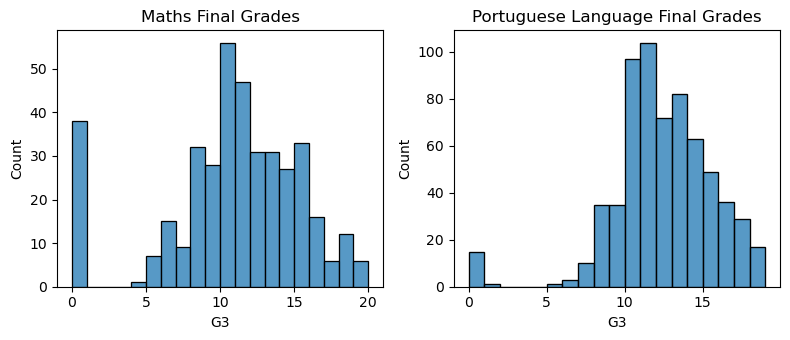

In [27]:
#Histogram of final grades(G3) in Maths and Portuguese Language
plt.rcParams["figure.figsize"] = [8.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

sns.histplot(data=grades_mat, x="G3",binwidth=1,ax=axes[0]).set(title='Maths Final Grades')
sns.histplot(data=grades_por, x="G3",binwidth=1,ax=axes[1]).set(title='Portuguese Language Final Grades')

plt.show()

Histograms allow us to see that Portuguese Language has higher average final grades than Maths. Let us see if this changes if we compare it by gender.

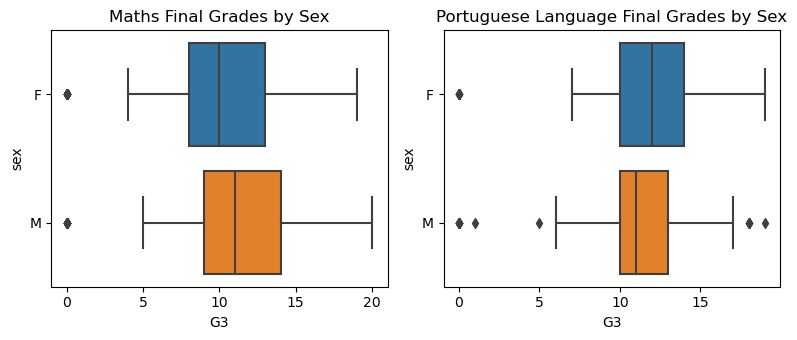

In [28]:
#Boxplots of final grades(G3) in Maths and Portuguese by gender
plt.rcParams["figure.figsize"] = [8.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

sns.boxplot(data=grades_mat, x="G3",y="sex",ax=axes[0]).set(title='Maths Final Grades by Sex')
sns.boxplot(data=grades_por, x="G3",y="sex",ax=axes[1]).set(title='Portuguese Language Final Grades by Sex')

plt.show()

We can see from these box plots that female students typically receive lower math final marks than their male counterparts. They do, however, score higher in Portuguese Language than male students.

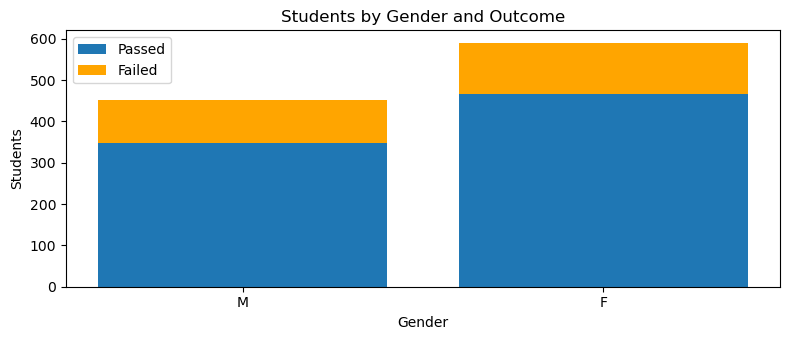

In [29]:
import matplotlib.pyplot as plt
# Bar chart showing the Student Outcome(Pass/Fail) by Gender
labels_Sex = ["M", "F"] 
# Passed by gender
male_passed = sum(grades.loc[grades['sex']=='M'].Pass) 
female_passed = sum(grades.loc[grades['sex']=='F'].Pass) 
Sex_passed = [male_passed, female_passed]
# Failed by gender
total_males = len(grades.loc[grades['sex']=='M'].Pass) 
total_females = len(grades.loc[grades['sex']=='F'].Pass)
male_failed = total_males - male_passed 
female_failed = total_females - female_passed
Sex_failed = [male_failed, female_failed]

# Make the plot
fig, ax = plt.subplots(1,1)
width = 0.8
ax.bar(labels_Sex, Sex_passed, width, label='Passed',color='tab:blue')
ax.bar(labels_Sex, Sex_failed, width, bottom=Sex_passed,label='Failed',color='orange')
ax.set_xlabel('Gender')
ax.set_ylabel('Students')
ax.set_title('Students by Gender and Outcome')
ax.legend()
plt.show()

Generally speaking, we can see that there are more female students than male students in the combined database, but it is challenging to determine whether there is a difference in the proportions of passing rates by looking at the graph. That is the reason why we will calculate the percentages.


In [30]:
print('Proportion of male students who passed:',round(male_passed*100/(male_passed+male_failed),1),'%')
print('Proportion of female students who passed:',round(female_passed*100/(female_passed+female_failed),1),'%')

Proportion of male students who passed: 76.8 %
Proportion of female students who passed: 78.8 %


The proportion of women obtaining a passing grade is quite close to men's. Gender might not have a significant effect on final grades, which is why we will not include it as a feature of the decision tree.

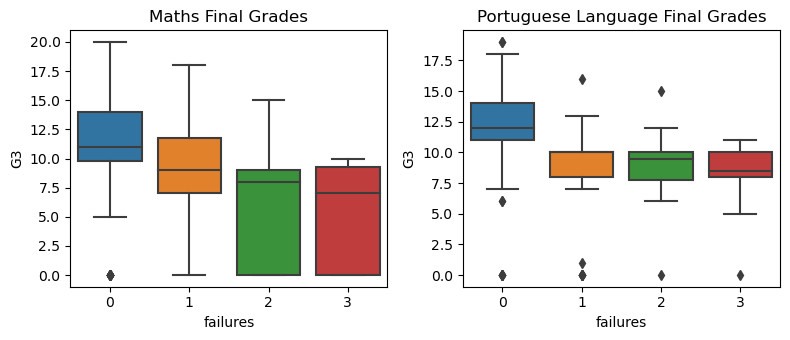

In [31]:
#Boxplots of failures and final grade(G3) in Maths and Portuguese
plt.rcParams["figure.figsize"] = [8.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

sns.boxplot(data=grades_mat, x="failures",y="G3",ax=axes[0]).set(title='Maths Final Grades')
sns.boxplot(data=grades_por, x="failures",y="G3",ax=axes[1]).set(title='Portuguese Language Final Grades')

plt.show()

When comparing boxplots of failures in Maths and Portuguese Language, we can see that, in general, the more failures, the lower the average final grade is. Also, the number of failures seems to have a bigger impact on Math final grades than on Portuguese final grades.

In [32]:
# Students by Failure and Pass
labels_failures = ['0', '1', '2','3'] 
failures0_passed = sum(grades.loc[grades['failures']==0].Pass)
failures1_passed = sum(grades.loc[grades['failures']==1].Pass)
failures2_passed = sum(grades.loc[grades['failures']==2].Pass)
failures3_passed = sum(grades.loc[grades['failures']==3].Pass)
failures_passed = [failures0_passed, failures1_passed, failures2_passed,failures3_passed]

failures0_failed = len(grades.loc[grades['failures']==0].Pass)-failures0_passed
failures1_failed = len(grades.loc[grades['failures']==1].Pass)-failures1_passed
failures2_failed = len(grades.loc[grades['failures']==2].Pass)-failures2_passed
failures3_failed = len(grades.loc[grades['failures']==3].Pass)-failures3_passed
failures_failed = [failures0_failed, failures1_failed, failures2_failed,failures3_failed]

print('Pass rate after failing 0 times:',round(failures0_passed*100/(failures0_passed+failures0_failed),1),'%')
print('Pass rate after failing 1 time:',round(failures1_passed*100/(failures1_passed+failures1_failed),1),'%')
print('Pass rate after failing 2 times:',round(failures2_passed*100/(failures2_passed+failures2_failed),1),'%')
print('Pass rate after failing 3 times:',round(failures3_passed*100/(failures3_passed+failures3_failed),1),'%')

Pass rate after failing 0 times: 85.0 %
Pass rate after failing 1 time: 51.7 %
Pass rate after failing 2 times: 33.3 %
Pass rate after failing 3 times: 30.0 %


The rate for passing a class after failing one time gets reduced from 85% to 51.7%, a 33.8% decrease. After failing two times, the pass rate gets reduced by 18.4%, leaving the students with only a 33.3% pass rate. When failing three times, the pass rate only reduces by 3.3%, leaving the pass rate at 30%.

This variable might have a significant effect on the final grade; that is the reason why we will include it as a feature in the decision tree.

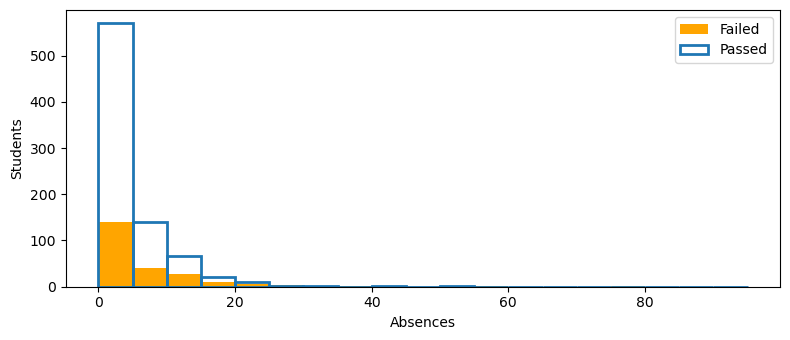

In [33]:
#Bar chart showing number of absences and student outcome
bins_absences = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]

fig, ax = plt.subplots(1, 1)
ax.hist(grades.loc[grades['Pass']==0].absences,bins=bins_absences,color='orange',label='Failed')
ax.hist(grades.loc[grades['Pass']==1].absences,bins=bins_absences,facecolor='none',edgecolor='tab:blue',linewidth=2,label='Passed')
ax.set_xlabel('Absences')
ax.set_ylabel('Students')
ax.legend()
plt.show()

A similar relationship between the number of failures and pass rate can be seen in the bar graph, where the pass rate decreases as the number of absences increases.
Additionally, we can see that as the number of absences rises, the proportion of failing students in each category grows.

It is a good idea to include absences as a feature of the decision tree.

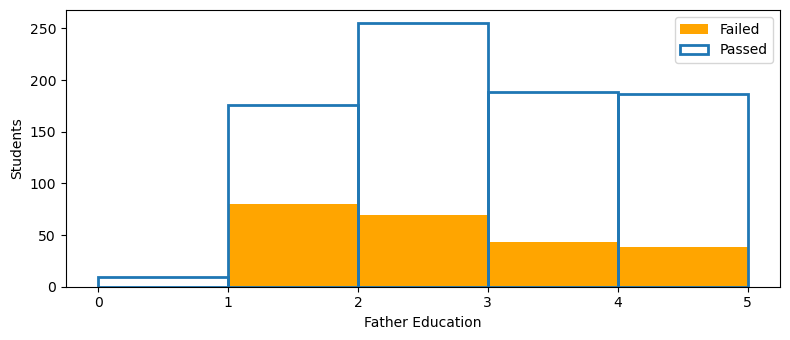

In [34]:
#Bar chart showing father education and student outcome#
bins_fedu = [0,1,2,3,4,5]

fig, ax = plt.subplots(1, 1)
ax.hist(grades.loc[grades['Pass']==0].Fedu,bins=bins_fedu,color='orange',label='Failed')
ax.hist(grades.loc[grades['Pass']==1].Fedu,bins=bins_fedu,facecolor='none',edgecolor='tab:blue',linewidth=2,label='Passed')
ax.set_xlabel('Father Education')
ax.set_ylabel('Students')
ax.legend()
plt.show()

In general, it is difficult to see a relationship between father education and student outcome. That is why we will calculate the pass rate.

In [35]:
labels_Fedu = ['0', '1', '2','3','4'] 
Fedu0_passed = sum(grades.loc[grades['Fedu']==0].Pass)
Fedu1_passed = sum(grades.loc[grades['Fedu']==1].Pass)
Fedu2_passed = sum(grades.loc[grades['Fedu']==2].Pass)
Fedu3_passed = sum(grades.loc[grades['Fedu']==3].Pass)
Fedu4_passed = sum(grades.loc[grades['Fedu']==4].Pass)
Fedu_passed = [Fedu0_passed,Fedu1_passed,Fedu2_passed,Fedu3_passed,Fedu4_passed]

Fedu0_failed = len(grades.loc[grades['Fedu']==0].Pass)-Fedu0_passed
Fedu1_failed = len(grades.loc[grades['Fedu']==1].Pass)-Fedu1_passed
Fedu2_failed = len(grades.loc[grades['Fedu']==2].Pass)-Fedu2_passed
Fedu3_failed = len(grades.loc[grades['Fedu']==3].Pass)-Fedu3_passed
Fedu4_failed = len(grades.loc[grades['Fedu']==4].Pass)-Fedu4_passed
Fedu_failed = [Fedu0_failed,Fedu1_failed,Fedu2_failed,Fedu3_failed,Fedu4_failed]

print('Pass rate when father has no studies:',round(Fedu0_passed*100/(Fedu0_passed+Fedu0_failed),1),'%')
print('Pass rate when father studied 4th grade:',round(Fedu1_passed*100/(Fedu1_passed+Fedu1_failed),1),'%')
print('Pass rate when father studied 5th-9th grade:',round(Fedu2_passed*100/(Fedu2_passed+Fedu2_failed),1),'%')
print('Pass rate when father studied secondary education:',round(Fedu3_passed*100/(Fedu3_passed+Fedu3_failed),1),'%')
print('Pass rate when father studied higher education:',round(Fedu4_passed*100/(Fedu4_passed+Fedu4_failed),1),'%')
#0=(None), 1=(4th grade), 2=(5th-9th grade), 3=(secondary education), 4=(higher education)

Pass rate when father has no studies: 100.0 %
Pass rate when father studied 4th grade: 68.8 %
Pass rate when father studied 5th-9th grade: 78.7 %
Pass rate when father studied secondary education: 81.4 %
Pass rate when father studied higher education: 83.0 %


We can observe a slight increase in the pass rate the higher the education level is, but the is no clear effect on the amount of "Passing" students overall. This variable will not be included as a feature of the decision tree.

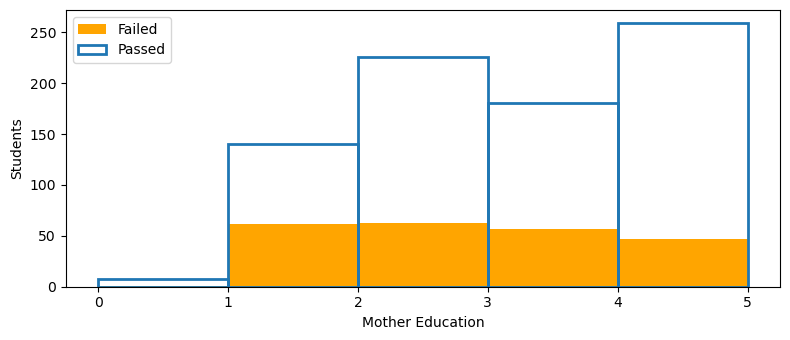

In [36]:
#Bar chart showing mother education and student outcome
bins_medu = [0,1,2,3,4,5]

fig, ax = plt.subplots(1, 1)
ax.hist(grades.loc[grades['Pass']==0].Medu,bins=bins_medu,color='orange',label='Failed')
ax.hist(grades.loc[grades['Pass']==1].Medu,bins=bins_medu,facecolor='none',edgecolor='tab:blue',linewidth=2,label='Passed')
ax.set_xlabel('Mother Education')
ax.set_ylabel('Students')
ax.legend()
plt.show()

We can observe from the bar chart that there may be a small relationship between mother education and student outcome proportions, which suggests that the pass rate may increase somewhat as mother education increases. Let's calculate the rates for each education level.

In [37]:
labels_Medu = ['0', '1', '2','3','4'] 
Medu0_passed = sum(grades.loc[grades['Medu']==0].Pass)
Medu1_passed = sum(grades.loc[grades['Medu']==1].Pass)
Medu2_passed = sum(grades.loc[grades['Medu']==2].Pass)
Medu3_passed = sum(grades.loc[grades['Medu']==3].Pass)
Medu4_passed = sum(grades.loc[grades['Medu']==4].Pass)
Medu_passed = [Medu0_passed,Medu1_passed,Medu2_passed,Medu3_passed,Medu4_passed]
Medu0_failed = len(grades.loc[grades['Medu']==0].Pass)-Medu0_passed
Medu1_failed = len(grades.loc[grades['Medu']==1].Pass)-Medu1_passed
Medu2_failed = len(grades.loc[grades['Medu']==2].Pass)-Medu2_passed
Medu3_failed = len(grades.loc[grades['Medu']==3].Pass)-Medu3_passed
Medu4_failed = len(grades.loc[grades['Medu']==4].Pass)-Medu4_passed
Medu_failed = [Medu0_failed,Medu1_failed,Medu2_failed,Medu3_failed,Medu4_failed]

print('Pass rate when mother has no studies:',round(Medu0_passed*100/(Medu0_passed+Medu0_failed),1),'%')
print('Pass rate when mother studied 4th grade:',round(Medu1_passed*100/(Medu1_passed+Medu1_failed),1),'%')
print('Pass rate when mother studied 5th-9th grade:',round(Medu2_passed*100/(Medu2_passed+Medu2_failed),1),'%')
print('Pass rate when mother studied secondary education:',round(Medu3_passed*100/(Medu3_passed+Medu3_failed),1),'%')
print('Pass rate when mother studied higher education:',round(Medu4_passed*100/(Medu4_passed+Medu4_failed),1),'%')
#0=(None), 1=(4th grade), 2=(5th-9th grade), 3=(secondary education), 4=(higher education)

Pass rate when mother has no studies: 88.9 %
Pass rate when mother studied 4th grade: 69.3 %
Pass rate when mother studied 5th-9th grade: 78.2 %
Pass rate when mother studied secondary education: 76.1 %
Pass rate when mother studied higher education: 84.6 %


The pass rate when the mother studied 4th grade (69.3%) increases by 8.9 percent when the mother studied 5th–9th grade (78.2%). Also, the pass rate when the mother studied secondary education (76.1%) increases by 8.5 percent when the mother studied higher education (84.6%).

Mother Education will be included as a feature for the decision tree.

# Cleaning the data

After obtaining useful information from our exploratory analysis, we will make a simple feature selection and remove features that are not relevant and that might lower our accuracy.

In [38]:
grades = grades.drop(['school','address','famsize','Pstatus','reason','guardian','traveltime','schoolsup','famsup','paid','activities','nursery','romantic','famrel','freetime','goout','Dalc','health','G1','G2','G3','Mjob','Fjob','Fedu','internet','higher',"Walc","studytime","sex"],axis=1)
grades.head()

,Pass,age,Medu,failures,absences
0,0,18,4,0,6
1,0,17,1,0,4
2,1,15,1,3,10
3,1,15,4,0,2
4,1,16,3,0,4


Let us look at the number of NANs

In [39]:
import pandas as pd
# Go through each input feature checking if there are any (and how many) NaNs 
Features = grades.columns.tolist() # Make a list of the feature names
print(Features)
for feature in Features:
    num = 0
    for i in range(0,len(grades)):
        if pd.isnull(grades.iloc[i][feature]) == True:
            num = num + 1
    print('NaNs for', feature ,'is', num)

['Pass', 'age', 'Medu', 'failures', 'absences']
NaNs for Pass is 0
NaNs for age is 0
NaNs for Medu is 0
NaNs for failures is 0
NaNs for absences is 0


We can see that we do not have missing values in our dataset. Also, we do not have any object types to convert into numbers. However, I will include the code to do so in case there is a variable that might increase the accuracy of the model, such as sex, higher education, or internet access.

In [26]:
#If we want to add categorical variables, we can do so by first transforming them to numerical
#Convert object types to numerical
#if grades.sex[0] == 'M' or grades.sex[0] == 'F':
   # grades['sex']=grades['sex'].map({'M' : 0, 'F' : 1})
    #grades['higher']=grades['higher'].map({'no' : 0, 'yes' : 1})
    #grades['internet']=grades['internet'].map({'no' : 0, 'yes' : 1})
#grades.head()

# Decision Tree

In [40]:
#Decision Tree Algorithm

#We separate into test and training to check the performance later
from sklearn.model_selection import train_test_split
X=grades.drop(['Pass'],axis=1) # Input variables
X_names = Features[1:] # Remove 'Pass' from feature names
y=grades['Pass'] # Target variable
y_names=['Failed','Passed'] # Target labels

#we set the test size in a three to one ratio. Also,
#we stratify so each portion of the dataset represents the overall dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2, stratify=y)  


from sklearn import tree
decision_tree = tree.DecisionTreeClassifier(max_depth = 3, random_state=7) #The depth of three gives us the best accuracy
decision_tree.fit(X_train,y_train)
y_pred=decision_tree.predict(X_test)

from sklearn import metrics
# Model Accuracy
y_test_pred = decision_tree.predict(X_test)
y_train_pred = decision_tree.predict(X_train)
print("Accuracy on training set:",round(metrics.accuracy_score(y_train, y_train_pred),2))
print("Accuracy on test set:",np.round(metrics.accuracy_score(y_test, y_pred),2))

# Feature importance
feature_importances_dict = {}
for i, name in enumerate(X_names): feature_importances_dict.update({name : decision_tree.feature_importances_[i]})

# Sort features in descending order of importance (need to use reverse=True for descending)  
feature_importances_sorted = dict(sorted(feature_importances_dict.items(), key=lambda x:x[1], reverse=True)) 

print('Features in order of importance:')   
for key in feature_importances_sorted:
    print(key)

Accuracy on training set: 0.81
Accuracy on test set: 0.82
Features in order of importance:
failures
absences
age
Medu


The tree obtained an accuracy of 0.81 on the training set and 0.82 on the test set. This is a good model since it does not overfit, and when used with real data, it is correct 82% of the time.

# Visualize the tree

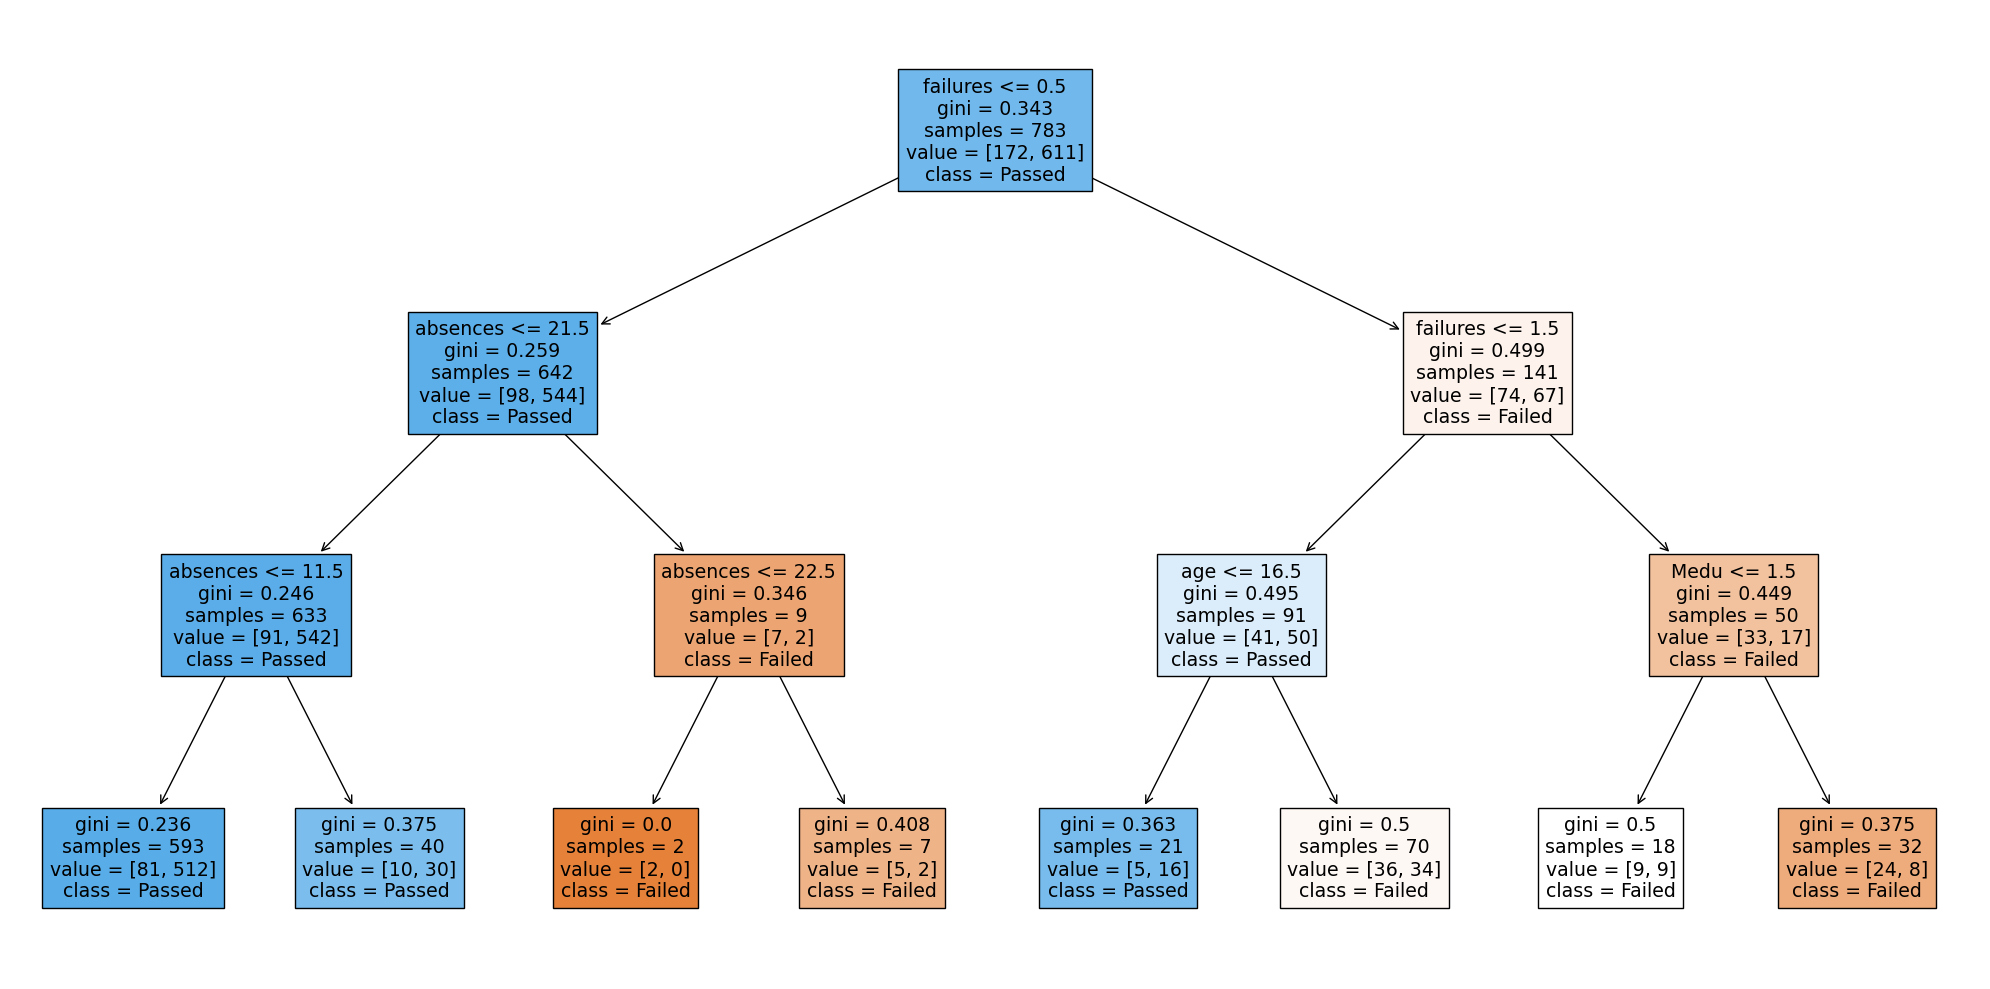

In [41]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(decision_tree,feature_names=X_names,class_names=y_names,filled=True) # _ stops annotations print-out

In this model, we can see that the decision rule starts by dividing students by the number of failures (failures<=0.5), leaving 172 students without failures on the left child node and classifying them in the "Passed" category, and 611 students with failures on the right child node and classifying them in the "Failed" category. The Gini impurity of the root node, the probability of incorrectly classifying a datapoint, is 0.343. 

Then, for the first right child node, our tree divides the students again by number of absences (absences<=21) creating two extra child nodes, 98 students with less than or equal to 21.5 absences are classified as "Passed" and sent to the left second child node, and 544 students with more than 21.5 absences are classified as "Failed". The Gini impurity of the first left-side child node is 0.246.After this, our tree creates four extra nodes, two for each child node, that classify students in the same category as the child node.

To continue,this time for the first right child node, our tree divides the 611 students by number of failures (failures<=1.5) creating two extra child nodes, 74 students with less than or equal to 1.5 failures are classified as "Passed" and sent to the left second child node; 67 students with more than 1.5 failures are classified as "Failed". However, this time, the Gini impurity of 0.499 is quite high. After this, our tree creates four extra nodes, two for each child node, that classify students by age<=16.5 and by Medu<=1.5, again with high Gini impurities of 0.495 and 0.499. Only students with an age lower than 16.5 are classified as "Passed", the rest are classified as "Failed".

By summing up all of the accurate classifications from the leaf nodes and dividing by the total number of samples, we can determine it the accuracy of the model:

Accuracy on training set: 0.81
Accuracy on test set: 0.82

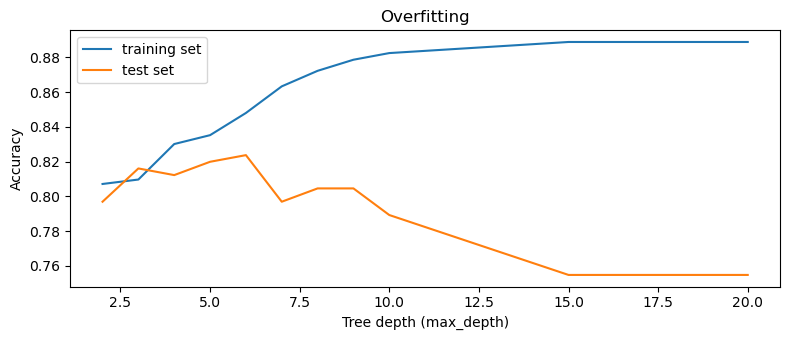

In [42]:
# Accuracy as a function of max_depth 

max_depth_vals = [2,3,4,5,6,7,8,9,10,15,20]
accuracytrain_list=[]
accuracytest_list=[]
for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=i)
    decision_tree.fit(X_train,y_train)
    # Training set
    ytrain_pred = decision_tree.predict(X_train)
    accuracy_train = metrics.accuracy_score(y_train, ytrain_pred)
    accuracytrain_list.append(accuracy_train)
    # Test set
    ytest_pred = decision_tree.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, ytest_pred)
    accuracytest_list.append(accuracy_test)

# Plot accuracy as a function of max_depth
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
line1, = ax.plot(max_depth_vals,accuracytrain_list,label='training set')
line2, = ax.plot(max_depth_vals,accuracytest_list,label='test set')
plt.legend(handles=[line1, line2])
plt.title("Overfitting")
plt.xlabel("Tree depth (max_depth)")
plt.ylabel("Accuracy")
plt.show()

In this plot, we can see that the best tree depth is between 3 and 4, because after that, the difference between the training and test sets increases greatly, meaning that after a certain depth, our model tends to memorize the data instead of generalising, thus overfitting the data.

In [43]:
# 5-fold cross-validation to compute the mean accuracy of a tree with max length of 3
#We separate the dataset in 5 part to obtain the average of 5 different accuracies.
import math
from sklearn.model_selection import cross_val_score
maxDepth = 3
k=5
decision_tree = tree.DecisionTreeClassifier(max_depth=maxDepth, random_state=2)
cv_scores = cross_val_score(decision_tree, X, y, cv=k)
print('Cross-validation scores are:',cv_scores)

# Compute the average of the accuracies and its error
avg = sum(cv_scores)/len(cv_scores)
sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
print('Average performance for a tree depth of',maxDepth,'is:',np.round(avg*100,1),'+/-',np.round(sd*100,1),'%')

Cross-validation scores are: [0.77990431 0.78947368 0.77033493 0.80382775 0.8125    ]
Average performance for a tree depth of 3 is: 79.1 +/- 1.7 %


In [44]:
# 5-fold cross-validation to compute the mean accuracy of a tree with max length of 4
#We separate the dataset in 5 part to obtain the average of 5 different accuracies.
import math
from sklearn.model_selection import cross_val_score
maxDepth = 4
k=5
decision_tree = tree.DecisionTreeClassifier(max_depth=maxDepth, random_state=2)
cv_scores = cross_val_score(decision_tree, X, y, cv=k)
print('Cross-validation scores are:',cv_scores)

# Compute the average of the accuracies and its error
avg = sum(cv_scores)/len(cv_scores)
sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
print('Average performance for a tree depth of',maxDepth,'is:',np.round(avg*100,1),'+/-',np.round(sd*100,1),'%')

Cross-validation scores are: [0.77990431 0.80382775 0.79425837 0.80382775 0.79326923]
Average performance for a tree depth of 4 is: 79.5 +/- 1.0 %


Comparing the performance of the decision tree with a maximum depth of 3 and 4, we can observe that the average
performance of the tree with depth 4 (79.5 +/- 1.0 %) has a higher average and lower variance than a tree with a maximum depth of 3 with an average performance of (79.1 +/- 1.7 %).

## Accuracy using k-fold cross-validation

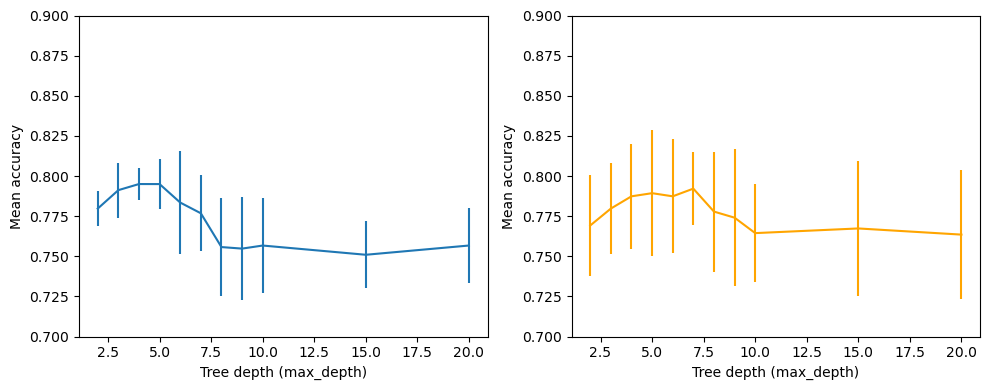

In [45]:
# 5-fold and 10 fold cross validation

from sklearn.model_selection import cross_val_score
import math

max_depth_vals = [2,3,4,5,6,7,8,9,10,15,20]

### 5-fold ###
k=5
mean_accuracy_cv_k5 = [] # mean accuracy over the k folds for each tree depth
sd_cv_k5 = [] # standard deviation of accuracy scores over the k folds for each tree depth

for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=i)
    cv_scores = cross_val_score(decision_tree, X, y, cv=k)
    avg = sum(cv_scores)/len(cv_scores)
    sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
    mean_accuracy_cv_k5.append(avg)
    sd_cv_k5.append(sd)
    
### 10-fold ###
k=10
mean_accuracy_cv_k10 = [] # mean accuracy over the k folds for each tree depth
sd_cv_k10 = [] # standard deviation of accuracy scores over the k folds for each tree depth

for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=i)
    cv_scores = cross_val_score(decision_tree, X, y, cv=k)
    avg = sum(cv_scores)/len(cv_scores)
    sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
    mean_accuracy_cv_k10.append(avg)
    sd_cv_k10.append(sd)
    
# Make the plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].errorbar(max_depth_vals,mean_accuracy_cv_k5,yerr=sd_cv_k5)
ax[0].set_xlabel("Tree depth (max_depth)")
ax[0].set_ylabel("Mean accuracy")
ax[0].set_ylim([0.70,0.9])

ax[1].errorbar(max_depth_vals,mean_accuracy_cv_k10,yerr=sd_cv_k10, color="orange")
ax[1].set_xlabel("Tree depth (max_depth)")
ax[1].set_ylabel("Mean accuracy")
ax[1].set_ylim([0.70,0.9])

plt.show()

The mean accuracy in the 5-fold cross-validation method peaks around 3 or 4 tree depth with low error bars. Meanwhile, the mean accuracy in the 10-fold cross validation peaks around 6 or 7 tree depth with high error bars.

## Feature Importances

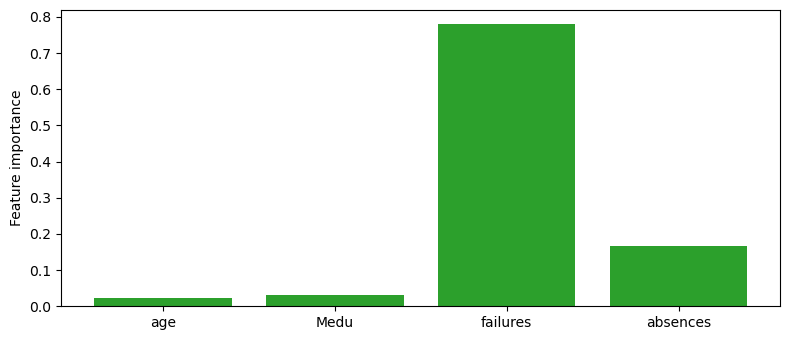

In [46]:
# Plot a histogram of feature importances using a fixed tree depth

def get_feature_importances(X,y,randomState,maxDepth):
    from sklearn import tree, model_selection
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, 
                                                                        random_state=randomState, stratify=y)  
    decision_tree = tree.DecisionTreeClassifier(max_depth = maxDepth, random_state=randomState)
    decision_tree.fit(X_train,y_train)
    return decision_tree.feature_importances_

maxDepth = 3

# Get feature importances for different train/test splits (by changing random_state in train_test_split()) and compute the average importance for each feature.
import random
random.seed(2)
feature_importances_summed = np.zeros(len(X_names))
n=100
for i in range(0,n):
    randomState = random.randint(0,1000)
    feature_importances = get_feature_importances(X,y,randomState,maxDepth)
    # Commented out the below 2 lines and replaced with 1 (better to use less lines of code!)
    #tmp = zip(feature_importances_summed,feature_importances)
    #feature_importances_summed = [(x + y) for (x, y) in tmp]
    feature_importances_summed = feature_importances_summed + feature_importances
feature_importances_mean = [number / n for number in feature_importances_summed]

fig, ax = plt.subplots(1,1)
ax.bar(X_names, feature_importances_mean,color='tab:green')
ax.set_ylabel('Feature importance')    
plt.show()

The level of importance in our  tree with a depth of three is failures first, followed by absences, Medu, and age. However, the importance of Medu and age are quite low.

## Random Forest Classifier

Next, we will compare the average performance for a tree depth of 3 (79.1 +/- 1.7%) with a random forest of 100 trees with a maximum depth of 4.

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_features='auto',criterion='gini',max_depth=4,random_state=3,oob_score=True)
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
print("Accuracy on training set:",round(metrics.accuracy_score(y_train, y_train_pred),2))
y_test_pred = forest.predict(X_test)
print("Accuracy on test set:",round(metrics.accuracy_score(y_test, y_test_pred),2))
print("OOB score:",round(forest.oob_score_,2)) # Alternative to test set validation method 

Accuracy on training set: 0.84
Accuracy on test set: 0.82
OOB score: 0.79


Our random forest classifier obtained an accuracy of 0.82 on the training set and 0.81 on the test set, with an out of the bag score of 0.79. This is a good model since it does not overfit, and when used with real data, it is correct 81% of the time.

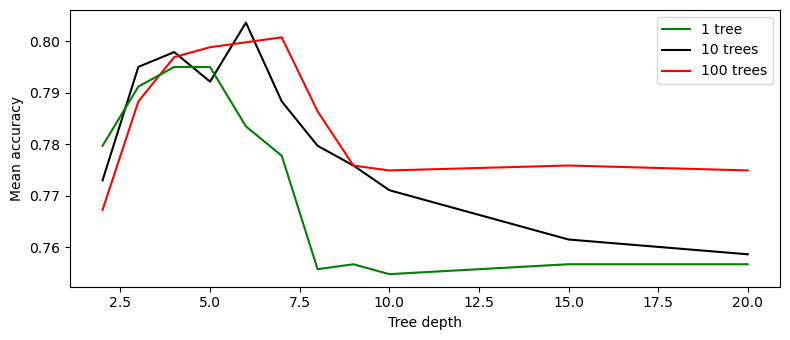

In [49]:
#Plot of mean performance of the random forest algorithm
from sklearn.model_selection import cross_val_score
import math
from sklearn.ensemble import RandomForestClassifier
max_depth_vals = [2,3,4,5,6,7,8,9,10,15,20]
n_estimators_vals = [10,100]
mean_accuracy_store = []
sd_accuracy_store = []
k=5
for i, value in enumerate(n_estimators_vals):
    mean_accuracy_cv = []
    sd_cv = []
    for val in max_depth_vals:
        forest = RandomForestClassifier(n_estimators=value,bootstrap=True,max_features="auto",criterion='gini',max_depth=val,random_state=i,oob_score=False)
        cv_scores = cross_val_score(forest, X, y, cv=k)
        avg = sum(cv_scores)/len(cv_scores)
        sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
        mean_accuracy_cv.append(avg)
        sd_cv.append(sd)
    mean_accuracy_store.append(mean_accuracy_cv)
    sd_accuracy_store.append(sd_cv)

fig = plt.figure()
ax = plt.axes()
line2, = ax.plot(max_depth_vals,mean_accuracy_store[0],color='black',label='10 trees')
line3, = ax.plot(max_depth_vals,mean_accuracy_store[1],color='red',label='100 trees')

# Now find accuracy scores as a function of tree depth for a single decision tree
mean_accuracy_cv = []
for i in range(0,len(max_depth_vals)):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth_vals[i], random_state=3)
    cv_scores = cross_val_score(decision_tree, X, y, cv=k)
    avg = sum(cv_scores)/len(cv_scores)
    mean_accuracy_cv.append(avg)
    
line1, = ax.plot(max_depth_vals,mean_accuracy_cv,color='green',label='1 tree')


plt.legend(handles=[line1, line2, line3])
plt.xlabel("Tree depth")
plt.ylabel("Mean accuracy")
plt.show()


In this graph, mean accuracy peaks at different tree depths depending on the number of trees in the random forest. A decision tree peaks around the depth of 3 or 4, a random forest with 10 trees peaks around the depth of 6 or 7, and a random forest with 100 trees peaks at a depth of 8.

## Results

Overall, the accuracy on the test set of the decision tree classifier with a depth of three is 0.82 with the following features in order on importance: failures, absences, age and Mother Education. 

To measure the performance, k-fold cross validation was used and we found that the mean accuracy in the 5-fold cross validation peaks around 3-4 with low error bars. Meanwhile, the mean accuracy in the 10-fold cross validation peaks around 6-7 with high error bars.

Comparing the performance of the decision tree with a maximum depth of 3 and 4, we can observe that the average
performance of the tree with depth 4 (79.5 +/- 1.0 %) has a higher average and lower variance than a tree with a maximum depth of 3 with an average performance of (79.1 +/- 1.7 %).

Next we used a random forest classifier of 100 trees with depth of 4 to compare it with our original tree of depth 3 and found that the random forest obtained an accuracy of 0.84 on the training set and 0.82 on the test set, with an out of the bag score of 0.79.

This algorithm is reasonably good at predicting secondary level student performance in Portugal. Both models, decision tree and random forests are equally good at solving this classification  problem in specific.


## Conclusion

In conclusion, a decision tree with a depth of 3 was used to classify student performance (Pass or Fail) on a dataset containing information about the grades of 382 students in Math and Portuguese Language. Two preprocessed datasets were used and combined into one. Then, to select the features for the model, an exploratory analysis was performed.

Using the libraries Scikit-Learn and Matplotlib, we were able to create the tree using the following features: number of failures, number of absences, mother's education, and age. Then we separated the dataset into a 3:1 ratio for training and testing. To evaluate the model, the max depth function and k-fold cross-validation were selected. In addition, we compared the performance of the decision tree model with random forests of 10 and 100 trees.

Overall,both models, decision tree and random forest, are good at classifying secondary student performance in Portugal into "Pass" or "Fail" categories with 82% accuracy. The main features used in these models are the number of previous failures and the number of absences.

##Bibliography

Data source:

UC Irvine. “Student Performance Data Set.” UCI Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/Student+Performance. 

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://www3.dsi.uminho.pt/pcortez/student.pdf

Support material:
Roig, Mario Gutierrez. “Artificial Intelligence and Machine Learning with Applications:  Decision Trees and Random Forests: The Titanic Disaster.” Moodle, University of Essex, https://moodle.essex.ac.uk/course/view.php?id=15076§ion=10. 
